In [101]:
import sys, os
import time
import argparse
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.abspath(os.path.join('..') + '/scripts/sig_gen/')) # import sig gen folder
from sg_smb100a_generate_frequency_sweep_notebook_1 import SG_SOCK # Import the Signal Generator Socket class 

#-----------------------import libraries for Spectrum analyzer----------------#
sys.path.insert(0, os.path.abspath(os.path.join('..') + '/scripts/spec_ana/ms2090a/'))
from sa_ms2090a_set_maxhold_read_trace_1 import SA_SOCK        # Import the Spectrum Analyser Socket class

#--------Import scpi database for Signal Generator and Spectrum analyzer ----------#
sys.path.insert(0, os.path.abspath(os.path.join('..') + '/resources/'))
from scpi_database import SGCmds
from scpi_database import SACmds

# -----------------Connection Settings----------------------
SG_PORT = 5025                    # default SMB R&S port 
SG_HOST = '10.20.7.1'             # smb100a signal generator IP
SG_ADDRESS = (SG_HOST, SG_PORT)
SA_HOST = '10.20.7.4'             # Anritsu spectrum analyzer IP temporary
SA_PORT = 9001                    # Anritsu spectrum analyzer port 
SA_ADDRESS = (SA_HOST, SA_PORT)
#-----------------------------------------------------------
# ----------------Initialization of Variables---------------    
DEFAULT_TIMEOUT = 1        # Default socket timeout
RF_OFF = 0
RF_ON = 1

SHORT_DELAY = 0.1
LONG_DELAY = 1

#-----------------SA initialization Variables----------
NUMPOINTS = 631     # Number of measurement points (Max=625)
RBW = 3e6           # Resolution BW of spectrum analyser
VBW = 3e6           # Video BW of spectrum analyser

In [102]:
#-------------------SG_SMB100A Setup-------------------------#
def setupSG():  
    print('/------Setup signal generator Class---------/\n')
    SG = SG_SOCK()                                 # Call main class
    SG.connectSG(SG_ADDRESS)    
    SG.setSGCmd(SGCmds['rf_state'], RF_ON)
    SG.setSGCmd(SGCmds['power'], -20) 
    print('/------End of Setup Signal Generator Setup---------/\n\n')
    return SG

In [103]:
# Set up parameters to be parsed 
start_freq = 100e6 # the start frequency incl. units (Hz)')
stop_freq = 2e9    # the stop frequency incl. units (Hz)')
step_freq = 6e6  # the step frequency incl. units (Hz)')
dwel_time = 0.6    # the sweep dwell time (ms)')


In [104]:
#------------------------SA_MS2090A Setup-------------------------#
def setupSA():
    print('/------Setup spectrum analyser---------/')
    SA = SA_SOCK()
    SA.connectSA((SA_ADDRESS))
    SA.setSACmd(SACmds['reset_device'])
    SA.setSACmd(SACmds['start_freq'], start_freq)
    SA.setSACmd(SACmds['stop_freq'], stop_freq)
    SA.setSACmd(SACmds['sweep_points'], NUMPOINTS)
    SA.setSACmd(SACmds['rbw_auto'], 'off')
    SA.setSACmd(SACmds['vbw_auto'], 'off')
    SA.setSACmd(SACmds['att_level'], 10)
    SA.setSACmd(SACmds['ref_level'], -10)
    SA.setSACmd(SACmds['det_mode'], 'RMS') 
    SA.setSACmd(SACmds['trace1_mode'], 'MAX')
    SA.setSACmd(SACmds['marker1-state'], 'ON')
    print('/------End of Setup Spectrum Analyzer Setup---------/\n\n')
    return SA

In [105]:
#------------------------------ PLOT ---------------------------#
def plotTrace(freq_values, power_values, ref_level): 
    ''' Plot response

    This function plots power vs frequency maxhold 

    @params:    
        freq_values: integer list [in Hz]
        power_value: integer list [in dBm]
        ref_level: integer [in dBm]
    '''
    x_axis = freq_values
    y_axis = power_values
    plt.figure(figsize=(10,10))
    plt.plot(x_axis, y_axis)
    plt.xlabel('Frequency in GHz', fontsize = 16)
    plt.ylabel('Power in dBm', fontsize = 16)
    plt.title('Sweep Maxhold Plot')
    plt.ylim(-110, ref_level)
    plt.show()


In [106]:
print('\n/--------- Running main Code ---------/') 

sg = setupSG()
time.sleep(1) 
sa = setupSA()
time.sleep(1) 


/--------- Running main Code ---------/
/------Setup signal generator Class---------/

Connected to: Rohde&Schwarz,SMB100A,1406.6000k03/183286,4.20.028.58
/------End of Setup Signal Generator Setup---------/


/------Setup spectrum analyser---------/
Connected to: Anritsu,MS2090A,2234010,V2022.9.1
/------End of Setup Spectrum Analyzer Setup---------/




In [107]:
'''
The following block of code generates a sweep frequency of the signal generator
at 100MHz step
@params:
        start_freq      : start frequency in Hz (not less than 9 kHz)
        stop_freq       : stop frequency in Hz (not more than 6 GHz)
        step_freq       : step frequency in Hz (default = 100 MHz)
        dwel_time       : duration of frequency output in ms (default=1000 ms)
''' 
# Set and Display SG start frequency
sg.setSGCmd(SGCmds["start_freq"], start_freq)
start_freq_recvd = sg.getSGCmd(SGCmds["start_freq"]).decode()
print(f'Signal Generator Start Frequency = {float(start_freq_recvd) / 1e6} MHz') 

# Set and Display SG stop frequency
sg.setSGCmd(SGCmds["stop_freq"], stop_freq)
stop_freq_recvd = int(sg.getSGCmd(SGCmds["stop_freq"]).decode())
print(f'Signal Generator Stop Frequency = {float(stop_freq_recvd) / 1e9} GHz')

centFreq = (int(float(start_freq)) + int(float(stop_freq))) / 2
span = int(float(stop_freq)) - int(float(start_freq))    
span_recvd = int(sg.getSGCmd(SGCmds['span_freq']).decode())
print(f"Sweep Span = {span_recvd / 1e9} GHz")

# 1. Set the sweep range
sg.setSGCmd(SGCmds['cent_freq'], centFreq)
centFreq_recvd = int(sg.getSGCmd(SGCmds['cent_freq']).decode())
print(f"Sweep Center Frequency = {centFreq_recvd / 1e9} GHz")
sg.setSGCmd(SGCmds['span_freq'], span)

# 2. Select linear or logarithmic spacing
sg.setSGCmd(SGCmds['sweep_freq_spac_conf'], 'LIN')

# 3. Set the step width and dwell time
sg.setSGCmd(SGCmds['sweep_freq_step'], f'{step_freq}')
step_freq_recvd = int(float(sg.getSGCmd(SGCmds['step_freq']).decode()))
print(f"Step Frequency = {step_freq_recvd / 1e9} GHz")
sg.setSGCmd(SGCmds['sweep_freq_dwell'], f'{dwel_time}')

# 4. Select the trigger mode
sg.setSGCmd(SGCmds['sweep_freq_trig'], 'SING')

# 5. Select sweep mode and activate the sweep
sg.setSGCmd(SGCmds['sweep_freq_mode'], 'AUTO')
sg.setSGCmd(SGCmds['freq_mode'], 'SWE')

# -------------- Display Spectrum Analyzer Settings
# Read and print Spectrum Analyzer start frequency
start_freq = sa.getSACmd(SACmds["start_freq"])
print(f'Spectrum Analyzer Start Frequency = {float(start_freq) / 1e6} MHz') 

# Read and print SA stop frequency
stop_freq = int(sa.getSACmd(SACmds["stop_freq"]).decode())
print(f'Spectrum Analyzer Stop Frequency = {float(stop_freq) / 1e9} GHz')
print(f"Spectrum Analyzer Attenuation set to {sa.getSACmd(SACmds['att_level']).decode()} dB")
print(f"Spectrum Analyzer Reference Level set to {sa.getSACmd(SACmds['ref_level']).decode()} dBm")
# ------------ End of Display Spectrum Analyzer Settings

# 6. Trigger the sweep     
sg.setSGCmd(SGCmds['sweep_freq_exec'])
print('Executing sweep...')
# ----------------End of Signal Generator Setup Sweep Parameters -----------------------

# Wait until the sweep is finished
run_time_delay = int((float(stop_freq) - float(start_freq)) * (float(dwel_time) / float(step_freq)))
for count in range(0, run_time_delay, 10):
    time.sleep(10)          # wait for sweep to complete  
    # print(f'count = {count}...')
    print('Sweeping...')

Signal Generator Start Frequency = 100.0 MHz
Signal Generator Stop Frequency = 2.0 GHz
Sweep Span = 1.9 GHz
Sweep Center Frequency = 1.05 GHz
Step Frequency = 0.001 GHz
Spectrum Analyzer Start Frequency = 100.0 MHz
Spectrum Analyzer Stop Frequency = 2.0 GHz
Spectrum Analyzer Attenuation set to 10 dB
Spectrum Analyzer Reference Level set to -10 dBm
Executing sweep...
Sweeping...
Sweeping...
Sweeping...
Sweeping...
Sweeping...
Sweeping...
Sweeping...
Sweeping...
Sweeping...
Sweeping...
Sweeping...
Sweeping...
Sweeping...
Sweeping...
Sweeping...
Sweeping...
Sweeping...
Sweeping...
Sweeping...


Power and Frequency Values acquired...
Displayed plot...


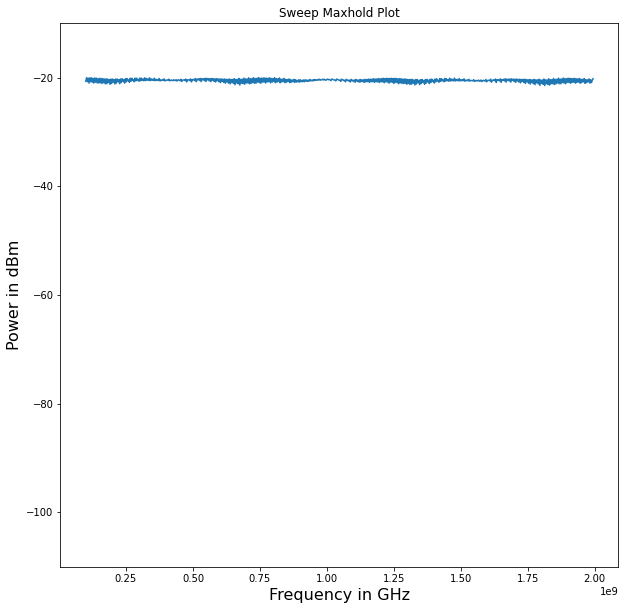

Signal Generator socket Disconnected
Spectrum Analyzer socket Disconnected
End of program.


In [108]:
''' Read trace data
        
This block of code reads the power trace data and calculates the trace frequency points

'''         
    
freq_values = []
power_values = [] 

# Confugure trace data format to be Ascii
sa.setSACmd(SACmds['data_format'], 'ASC')

# Set single sweep
sa.setSACmd((SACmds['sing_sweep_state']), 'OFF')

# --------------- Get trace data power values ------------------  
# sa.getSACmd((SACmds['trace_data']), 1)     # Command not working, replaced by the chunk of code below
sa.sendall(bytes('TRACE:DATA? 1\n', encoding = 'utf8'))
time.sleep(SHORT_DELAY)
try:
    return_str = sa.recv(8092)
except socket.timeout:
    raise StopIteration('No data received from instrument') 
# -------------------- End of trace data power values reading -------


# --------------- Trace data power values conditioning -------------------
power_data = return_str
power_data = power_data.decode()
power_data = str(power_data)
power_data = power_data.split(',')              # Makes variable a list
power_data.pop(0)
power_data = [float(x) for x in power_data]
    
No_of_Sweep_Points = int(sa.getSACmd(SACmds['sweep_points']).decode())   # Get No. of Sweep Points
power_values = power_data
# -------------------- End of trace data power values conditioning -------

freq_step_size = int((float(stop_freq) - float(start_freq)) / (No_of_Sweep_Points))
for i in range(0, (No_of_Sweep_Points - 1), 1):
    freq_values.append(int(float(start_freq)) + (i * freq_step_size))

print('Power and Frequency Values acquired...')

ref_level = int(sa.getSACmd(SACmds['ref_level']).decode())

print('Displayed plot...')

plotTrace(freq_values, power_values, ref_level)

sg.setSGCmd(SGCmds['rf_state'], RF_OFF)
sg.closeSGSock()
sa.closeSASock()
    
print('End of program.')